# 物理概念和过程

用以描述物理概念和过程的 IDS，数据源自物理建模和数值计算程序的结果，例如：

  - 平衡输运：equilibrium, core_profiles, core_transport, core_sources...
  - 物理过程：wave, MHD, turbulence...

对于这类 IDS ，{{FyTok}} 通过Module Plugin机制绑定相对独立的功能模块，然后根据 IMAS Ontology 描述的依赖关系，构建工作流实现集成建模。平衡和芯部输运问题式传统集成建模的主要问题，下图为 1.5 维芯部输运的工作流：

 ![fytok_flow](./figures/FyTok_en.png)

## equilibirum
`equilibirum` 提供二维轴对称托卡马克磁平衡的描述。



### 创建 `equilibrium` 实例

由 `geqdsk` 文件创建`equilibrium` 实例，默认调用插件 `fy_eq`，提供基础的磁面分析计算。

In [2]:
from fytok.modules.equilibrium import Equilibrium

equilibrium = Equilibrium("file+geqdsk://./data/g070754.05000#equilibrium")

2024-07-30 11:01:47,482 [   fytok]  VERBOSE: Load module fytok.plugins.modules.equilibrium.fy_eq
2024-07-30 11:01:47,486 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_geqdsk


FileNotFoundError: [Errno 2] No such file or directory: '/home/salmon/workspace/fytok_tutorial/user_guide/data/g070754.05000'

In [ ]:
from spdm.core.file import File

with File("output/equilibrium.gfile", mode="w", format="geqdsk") as f:
    f.write({"description": "just a test", "equilibrium": equilibrium})

2024-04-23 09:22:51,141 [    spdm]     INFO: Load module spdm.mesh.mesh_rectilinear


### 可视化

#### 2D 磁面：

给出当前时间片的二维磁场位形（`equilibrium.time_slice.current.profiles_2d.psi`）

In [4]:
import spdm.view.sp_view as sp_view
profiles_2d=equilibrium.time_slice.current.profiles_2d
fig=sp_view.display(profiles_2d.psi)

NameError: name 'equilibrium' is not defined

#### 1D 位形分布
绘出当前时间片的一维 profile，磁面坐标为为 $\psi$ `equilibrium.time_slice.current.profiles_1d.psi`

In [ ]:
equilibrium.refresh(time=0.0)
eq_profiles_1d=equilibrium.time_slice.current.profiles_1d

2024-04-23 09:22:51,430 [    spdm]     INFO: Refresh module fytok.plugins.equilibrium.dummy


In [ ]:
eq_profiles_1d.grid.psi_norm

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 

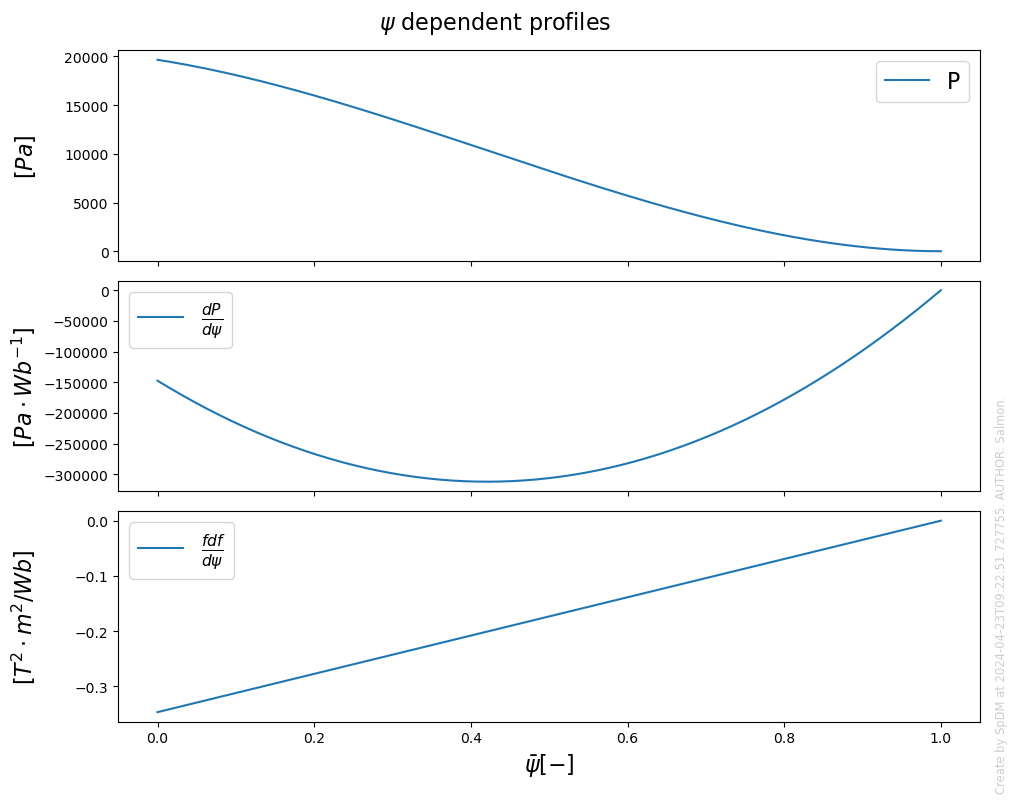

In [ ]:
profs = sp_view.plot(
    eq_profiles_1d.grid.psi_norm,
    eq_profiles_1d.pressure,
    eq_profiles_1d.dpressure_dpsi,
    eq_profiles_1d.f_df_dpsi,
    x_label=r"$\bar{\psi}[-]$",
    title=r"$\psi$ dependent profiles",
)

### `class Equilibrium`

除了 $\psi$, $ff^{\prime}$, $p$ 等少数基础信息，其他物理量可通过 `fy_eq` 实时演算获得。

```{eval-rst}

.. autoclass:: fytok.modules.Equilibrium.EquilibriumGlobalQuantities
    :members:
    :show-inheritance: True

.. autoclass:: fytok.modules.Equilibrium.EquilibriumProfiles1D
    :members:
    :undoc-members:
    :show-inheritance: True

.. autoclass:: fytok.modules.Equilibrium.EquilibriumProfiles2D
    :members:
    :undoc-members:
    :show-inheritance: True

.. autoclass:: fytok.modules.Equilibrium.EquilibriumTimeSlice
    :undoc-members: profiles_1d,profiles_2d,global_quantities,vacuum_toroidal_field
    :show-inheritance: True

.. autoclass:: fytok.modules.Equilibrium.Equilibrium
    :members: time_slice
    :member-order: bysource
    :show-inheritance: True

```

## core_profiles
`core_profiles` 芯部分布位形。



``` {note}
`core_profiles.profiles_1d` 以归一化的 $\bar{\rho}$ 为磁面坐标，与 `equilibrium.profiles_1d`采用 $\psi$ 作为磁面坐标不同。

```

### 创建`core_profiles`实例

由专有数据文件，按照预定义的语义读取并转换成 IMAS Ontology。这里`iterprofiles`所代表的`xls`文件中保存了一系列芯部物理量分布。

In [ ]:
from fytok.modules.core_profiles import CoreProfiles

core_profiles = CoreProfiles(f"file+iterprofiles://./data/profiles.xls#core_profiles")

2024-04-23 09:22:52,412 [    spdm]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2024-04-23 09:22:52,471 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 


### 可视化

绘出一维分布

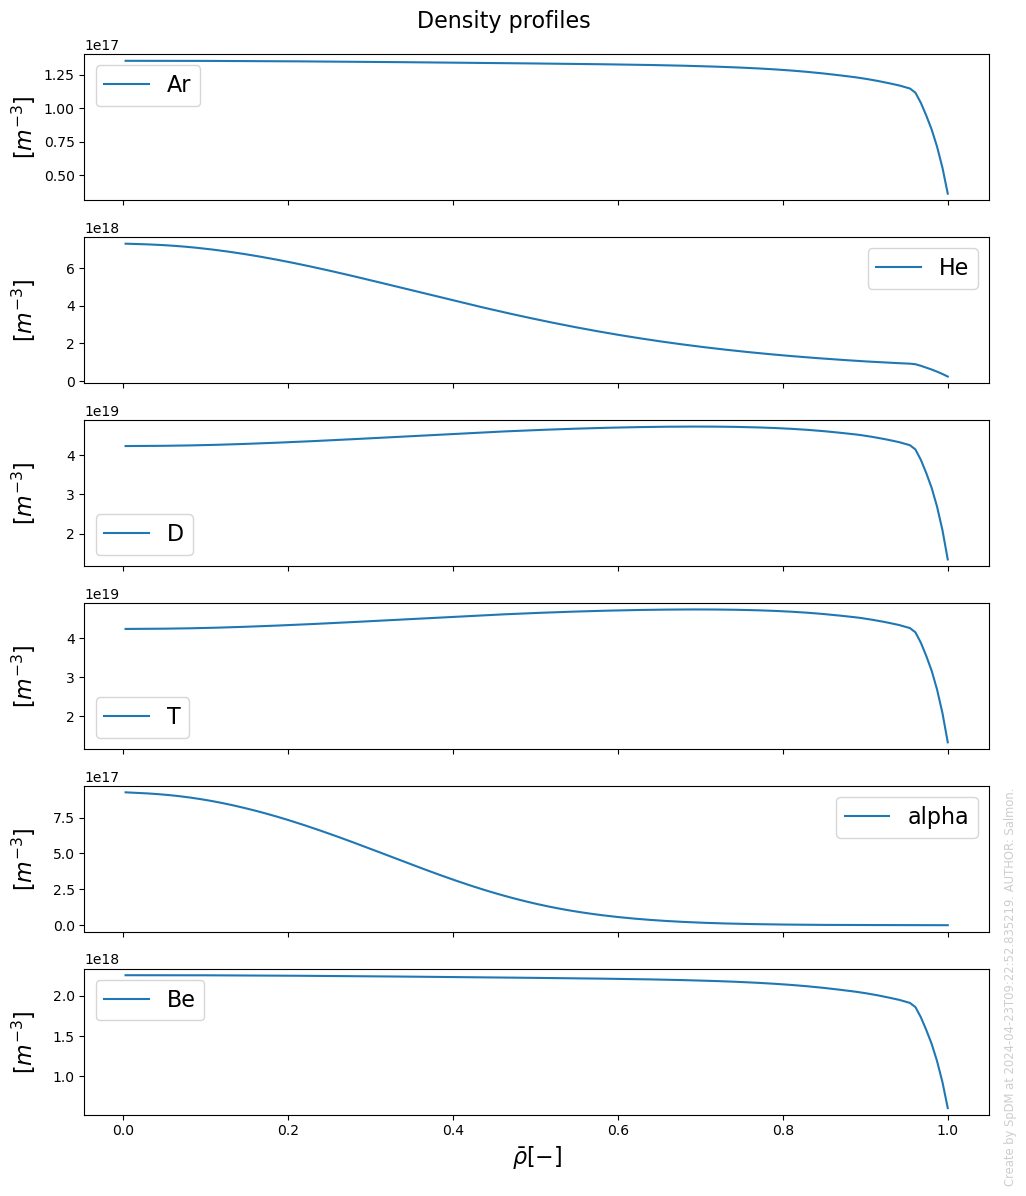

In [ ]:
import spdm.view.View as sp_view
x=core_profiles.time_slice.current.profiles_1d.grid.rho_tor_norm
fig = sp_view.plot(
    x,
    *[(ion.density(x),ion.label) for ion in core_profiles.time_slice.current.profiles_1d.ion],
    x_label=r"$\bar{\rho}[-]$",
    y_label=r"$[m^{-3}]$",
    title="Density profiles",
)

### `class CoreProfiles`

```{eval-rst}
 
.. autoclass:: fytok.modules.CoreProfiles.CoreProfiles1D
    :members: 
    :undoc-members:
    :show-inheritance: True

.. autoclass:: fytok.modules.CoreProfiles.CoreProfilesTimeSlice
    :undoc-members: profiles_1d 
    :show-inheritance: True

.. autoclass:: fytok.modules.CoreProfiles.CoreProfiles
    :members: time_slice
    :member-order: bysource
    :show-inheritance: True

```

## core_transport
`core_transport` 芯部输运系数


### 创建 `core_transport`  实例

In [ ]:
import numpy as np
from fytok.modules.CoreTransport import CoreTransport
from spdm.core.Expression import Variable

R0 = 1.85
B0 = 1.8

_x = Variable(0, "rho_tor_norm", label=r"\bar{\rho}_{tor}")

x = np.linspace(0, 1, 128)

# Core profiles
r_ped = 0.96  # np.sqrt(0.88)
i_ped = np.argmin(np.abs(x - r_ped))

# Core Transport

Cped = 0.17
Ccore = 0.4
# Function( profiles["Xi"].values,bs_r_norm)  Cped = 0.2
chi = Piecewise([Ccore * (1.0 + 3 * (_x**2)), Cped], [(_x < r_ped), (_x >= r_ped)], label=r"\chi")
chi_e = Piecewise([0.5 * Ccore * (1.0 + 3 * (_x**2)), Cped], [(_x < r_ped), (_x >= r_ped)], label=r"\chi_e")

D = 0.1 * (chi + chi_e)

v_pinch_ne = -0.6 * D * _x / R0
v_pinch_Te = 2.5 * chi_e * _x / R0
v_pinch_ni = D * _x / R0
v_pinch_Ti = chi * _x / R0

time_slice = {
    "profiles_1d": {
        "grid_d": {"rho_tor_norm": x},
        "electrons": {
            "label": "e",
            "particles": {"d": D, "v": v_pinch_ne},
            "energy": {"d": chi_e, "v": v_pinch_Te},
        },
        "ion": [
            {
                "label": "D",
                "particles": {"d": D, "v": v_pinch_ni},
                "energy": {"d": chi, "v": v_pinch_Ti},
            },
            # {
            #     "label": "T",
            #     "particles": {"d": D, "v": v_pinch_ni},
            #     "energy": {"d": chi, "v": v_pinch_Ti},
            # },
            # {
            #     "label": "He",
            #     "particles": {"d": D, "v": v_pinch_ni},
            #     "energy": {"d": chi, "v": v_pinch_Ti},
            # },
        ],
    }
}
core_transport = CoreTransport({"model": [{"code": {"name": "dummy"}, "time_slice": [time_slice]}]})

NameError: name 'Piecewise' is not defined

### 可视化

In [ ]:
import spdm.view.View as sp_view

core_transport_1d = core_transport.model[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    core_transport_1d.grid_d.rho_tor_norm,
    *[
        [(ion.particles.d, f"$D_{{{ion.label}}}$"), (ion.particles.v, f"$v_{{{ion.label}}}$")]
        for ion in core_transport_1d.ion
    ],
    (core_transport_1d.electrons.particles.d, f"$D_e$"),
    (core_transport_1d.electrons.particles.v, f"$v_e$"),
    x_label=r"$\bar{\rho}$",
    y_label=r"$[m^{-3}]$",
)

NameError: name 'core_transport' is not defined

### `class CoreTransport`


```{eval-rst}

.. autoclass:: fytok.modules.CoreTransport.CoreTransportProfiles1D
    :members:
    :undoc-members:
    :show-inheritance: True

.. autoclass:: fytok.modules.CoreTransport.CoreTransport
    :members: time_slice
    :member-order: bysource
    :show-inheritance: True

```


## core_sources

### `class CoreSources`

```{eval-rst}

.. autoclass:: fytok.modules.CoreSources.CoreSourcesProfiles1D
    :members:
    :undoc-members:
    :show-inheritance: True

.. autoclass:: fytok.modules.CoreSources.CoreSources
    :members: time_slice
    :member-order: bysource
    :show-inheritance: True

```